In [189]:
import re
import pandas as pd
from pathlib import Path
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
import networkx as nx
from PIL import Image
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [3]:
data_path = Path('../data/')
search_res_html = (data_path / 'nidb_nimh_search_2021_09_09.html').read_text()

In [4]:
ipid_pat = re.compile(r'\?ipid=([0-9]*)')

In [272]:
ipids = pd.unique(re.findall(ipid_pat,search_res_html))

In [273]:
pjdf = []
for ipid in ipids:
    url_root = "https://intramural.nih.gov/search/"
    url = f'{url_root}searchview.taf?ipid={ipid}'
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    headings = [dd.text for dd in soup.findAll('div', attrs={'class':'headings'})]
    headings += [dd.text for dd in soup.findAll('span', attrs={'class': 'headings'})]
    if 'Show all' in page.text:
        raise ValueError
    row = {}
    row['url'] = url
    row['pj_num'] = soup.findAll('div', attrs={'class':'contentlabel'})[0].text
    for dd in soup.findAll(attrs={'class':'headings'}):
        head = dd.text
        if 'Lab Staff and Collaborators' in head:
            label = 'Lab Staff and Collaborators'
        elif 'External Collaborator' in head:
            label = 'External Collaborators'
        elif 'Publications Generated' in head:
            if 'See Project Bibliography' in head:
                more_refs = True
            label = 'Publications Generated'
        else:
            label = head.strip()
        if dd.name == 'div':
            childdata = dd.parent.findChild(attrs={'class':'data'})
            if childdata is not None:
                value = childdata.text.strip()
            else:
                value = dd.parent.find_next('div', attrs={'class':'data'}).text.strip()
        elif dd.name == 'span':
            if label in ['Lead Investigator', 'Principal Investigator']:
                names = dd.parent.parent.findChildren('td', attrs={'class': 'showname'})
                value = [nn.text.strip().split('\n')[0] for nn in names][0]
            elif label in 'Lab Staff and Collaborators':
                names = dd.parent.parent.findChildren('td', attrs={'class': 'showname'})
                value = [nn.text.strip().split('\n')[0] for nn in names]
            elif label in ['External Collaborators', 'Collaborators from other NIMH organizations']:
                value = []
                # find the collaborator table
                for collaborator in dd.parent.parent.findNext('table').findChildren('tr'):
                    name = collaborator.text.strip().split('\n')[0]
                    org = collaborator.findChild('td', attrs={'class':'showorg'}).text.strip()
                    value.append((name, org))
            elif label == 'Collaborators from other NIH organizations':
                value = []
                name = ""
                for lm in dd.findAllNext(['td', 'span']):
                    if lm.has_attr('class'):
                        if lm.attrs['class'][0] == 'showname':
                            if len(name) == 0:
                                name = lm.text.strip().split('\n')[0]
                            else:
                                value.append((name, np.nan))
                                name = lm.text.strip().split('\n')[0]
                        elif lm.attrs['class'][0] == 'showorg':
                            org = lm.text.strip().split('\n')[0]
                            if len(name) == 0:
                                value.append((np.nan, org))
                            else:
                                value.append((name, org))
                                name = ""
                        elif lm.attrs['class'][0] == 'headings':
                            break
            else:
                raise ValueError
        if value == ['']:
            break
        row[label] = value
    pjdf.append(row)

In [274]:
pj_df = pd.DataFrame(pjdf)

In [8]:
pj_df.to_pickle(data_path / 'pjdf.pkl')

In [9]:
pj_df.to_csv(data_path / 'pjdf.csv')

In [275]:
col_rn = {'Collaborators from other NIH organizations': 'NIH_collab',
          'Collaborators from other NIMH organizations': 'NIMH_collab',
          'External Collaborators': 'EM_collab'}
pj_df = pj_df.rename(columns=col_rn)

In [276]:
pj_df['Research Organization'] = pj_df['Research Organization'].str.strip()

In [277]:
pj_df['PI'] = pj_df['Principal Investigator'].str.strip().str.split('\n').str[0]
pj_df['PI'] = pj_df['PI'].fillna(pj_df['Lead Investigator'].str.strip())

In [278]:
pj_df['pj_text'] = pj_df['Goals and Objectives'] + pj_df['Summary']

In [161]:
pj_df

pj_num  \
0   MH000889-42   
1   MH001090-44   
2   MH002032-45   
3   MH002035-41   
4   MH002386-35   
5   MH002497-32   
6   MH002498-32   
7   MH002537-32   
8   MH002588-31   
9   MH002619-30   
10  MH002652-29   
11  MH002717-27   
12  MH002736-26   
13  MH002781-20   
14  MH002782-20   
15  MH002783-20   
16  MH002784-20   
17  MH002786-20   
18  MH002793-20   
19  MH002795-20   
20  MH002797-20   
21  MH002798-20   
22  MH002800-19   
23  MH002803-19   
24  MH002804-19   
25  MH002810-19   
26  MH002838-18   
27  MH002843-18   
28  MH002844-18   
29  MH002852-17   
30  MH002857-17   
31  MH002863-17   
32  MH002865-16   
33  MH002874-15   
34  MH002881-15   
35  MH002882-15   
36  MH002886-15   
37  MH002887-15   
38  MH002893-15   
39  MH002896-15   
40  MH002898-15   
41  MH002909-14   
42  MH002917-14   
43  MH002918-13   
44  MH002920-13   
45  MH002922-13   
46  MH002927-12   
47  MH002928-12   
48  MH002933-10   
49  MH002936-10   
50  MH002942-09   
51  MH002946-09   
52  MH002949-06   
53  MH002950-06   
54  MH002951-06   
55  MH002953-06   
56  MH002954-06   
57  MH002955-06   
58  MH002956-06   
59  MH002957-05   
60  MH002958-05   
61  MH002959-05   
62  MH002964-05   
63  MH002966-05   
64  MH002967-05   
65  MH002969-03   
66  MH002970-03   
67  MH002971-03   
68  MH002972-03   
69  MH002973-03   
70  MH002975-02   
71  MH002977-01   
72  MH002978-01   
73  MH002884-15   
74  MH002888-15   
75  MH002889-15   
76  MH002894-15   
77  MH002899-15   
78  MH002901-15   
79  MH002903-15   
80  MH002911-14   
81  MH002952-06   
82  MH002960-05   
83  MH002961-05   
84  MH002962-05   
85  MH002963-05   
86  MH002968-04   
87  MH002912-14   
88  MH002939-09   
89  MH002924-13   
90  MH002947-07   
91  MH002916-14   
92  MH002925-13   

                                                                                           Report Title  \
0            Dysregulation of Protein Synthesis in Fragile X Syndrome and Other Developmental Disorders   
1                                                  Studies of Central Nervous System Functional Anatomy   
2                                                                       Neural Coding of Visual Stimuli   
3                         Functional Anatomy of Perceptual and Attentional Systems in the Primate Brain   
4                                                                  Chemical Coding of Neurotransmission   
5                                      Functional Organization of the Cerebral Cortex and Basal Ganglia   
6                                                            Roles of Oxytocin and Vasopressin in Brain   
7                                          Psychobiology and Treatment of Perimenopausal Mood Disorders   
8                             The Neural Foundations for Memory and Social Cognition in the Human Brain   
9                                                            Neural Mechanisms of Motivation and Reward   
10                      Imaging of Neuropsychiatric Disorders with Developmental and Genetic Mechanisms   
11                          Neuroimaging of Brain Circuits and Molecular Mechanisms in Normal Cognition   
12                                     Neural Substrates of Stimulus Recognition and Association Memory   
13                                                 fMRI Studies of Pediatric Mood and Anxiety Disorders   
14                                      fMRI Studies of Risk for Mood and Anxiety Disorders in Children   
15                                                                    Functional MRI Method Development   
16                                                                      Neurogenesis in the Adult Brain   
17                    Mechanisms of Frustration and the Pathophysiology of Severe Irritability in Youth   
18                                                                     PET Radiopharmaceutical Sciences   
19                                                         Translational Evaluatio

# cluster at research organization level

In [279]:
pj_df.loc[:,['PI', 'Research Organization', 'Report Title']]

PI  \
0               Carolyn E Smith, PhD   
1              Miles  Herkenham, PhD   
2               Barry J Richmond, MD   
3          Leslie G Ungerleider, PhD   
4                   Lee E Eiden, PhD   
5              Charles R Gerfen, PhD   
6   Walter Scott Young, MD, PhD, MPH   
7                Peter J Schmidt, MD   
8                  Alex  Martin, PhD   
9               Barry J Richmond, MD   
10                Karen F Berman, MD   
11                Karen F Berman, MD   
12       Elisabeth Adams Murray, PhD   
13                  Daniel  Pine, MD   
14                  Daniel  Pine, MD   
15       Peter A Bandettini, BS, PhD   
16            Heather A Cameron, PhD   
17             Ellen  Leibenluft, MD   
18                Victor W Pike, PhD   
19                 Robert  Innis, MD   
20               Dietmar  Plenz, PhD   
21           Christian  Grillon, PhD   
22             Benjamin H White, PhD   
23                    Jun  Shen, PhD   
24        Kathleen R Merikangas, PhD   
25        Francis Joseph McMahon, MD   
26              David A Leopold, PhD   
27        Francis Joseph McMahon, MD   
28        Francis Joseph McMahon, MD   
29                 Robert  Innis, MD   
30         Carlos Alberto Zarate, MD   
31                Karen F Berman, MD   
32               Peter J Schmidt, MD   
33               Peter J Schmidt, MD   
34                    Zheng  Li, PhD   
35                    Zheng  Li, PhD   
36       Elisabeth Adams Murray, PhD   
37       Elisabeth Adams Murray, PhD   
38        Christopher Ian Baker, PhD   
39              David A Leopold, PhD   
40              David A Leopold, PhD   
41        Christopher Ian Baker, PhD   
42                Susan G Amara, PhD   
43         Leslie G Ungerleider, PhD   
44                 Alex  Martin, PhD   
45             Maryland  Pao, BA, MD   
46         Carlos Alberto Zarate, MD   
47             Bruno B Averbeck, PhD   
48               Peter J Schmidt, MD   
49              Carolyn E Smith, PhD   
50                Karen F Berman, MD   
51                Susan G Amara, PhD   
52              Armin  Raznahan, PhD   
53        Mario Alexander Penzo, PhD   
54            Yogita  Chudasama, PhD   
55        Kathleen R Merikangas, PhD   
56        Kathleen R Merikangas, PhD   
57   sarah Hollingsworth Lisanby, MD   
58                Mark H Histed, PhD   
59         Argyrios  Stringaris, PhD   
60             Arash  Afraz, PhD, MD   
61                 Soohyun  Lee, PhD   
62           Samer Saleh Hattar, PhD   
63          Elisha Prem Merriam, PhD   
64                Mark H Histed, PhD   
65            Melissa A Brotman, PhD   
66        Hugo Alejandro Tejeda, PhD   
67               Dietmar  Plenz, PhD   
68                Mark H Histed, PhD   
69                Mark H Histed, PhD   
70         Allison Carol Nugent, PhD   
71                 Robert  Innis, MD   
72        Mario Alexander Penzo, PhD   
73       Peter A Bandettini, BS, PhD   
74                  Robert  Cox, PhD   
75         Allison Carol Nugent, PhD   
76                    Jun  Shen, PhD   
77              David A Leopold, PhD   
78           James M Pickel, PhD, AB   
79             Barbara K Lipska, PhD   
80           George Raphael Dold, MS   
81            Yogita  Chudasama, PhD   
82              Adam G Thomas, DPhil   
83               Audrey E Thurm, PhD   
84                   Ashura  Buckley   
85              Theodore B Usdin, MD   
86           Francisco  Pereira, PhD   
87             Maryland  Pao, BA, MD   
88             Maryland  Pao, BA, MD   
89            James  Raber, DVM, PhD   
90                Susan G Amara, PhD   
91             Janet Elizabeth Clark   
92                   Jennifer S Wong   

                                         Research Organization  \
0           Section on Neuro-adaptation and Protein Metabolism   
1                            Section on Functional Neroanatomy   
2                     Section on Neural Coding and Computation   
3        

In [280]:
pj_df['Report Title'] = pj_df['Report Title'].str.strip()

In [281]:
manual_edits = [('Charles R Gerfen, PhD', 'Office of the Director', 'Functional Organization of the Cerebral Cortex and Basal Ganglia', 'Organization of the Cortex and Basal Ganglia'),
                ('Susan G Amara, PhD', 'Office of the Director', 'Office of the Scientific Director', 'Office of the Scientific Director'),
                ('Maryland  Pao, BA, MD', 'Office of the Clinical Director', 'Psychiatry Consultation Liaison Service Research', 'Psychiatry Consultation Liaison Service Research'),
                ('Adam G Thomas, DPhil', 'Functional MRI Core', 'Data Science and Sharing Team', 'Data Science and Sharing Team'),
                ('Audrey E Thurm, PhD', 'Office of the Clinical Director', 'Neurodevelopmental and Behavioral Phenotyping', 'Neurodevelopmental and Behavioral Phenotyping Service'),
                ('Ashura  Buckley', 'Office of the Clinical Director', 'Sleep and Neurodevelopment Service', 'Sleep and Neurodevelopment Service'),
                ('Francisco  Pereira, PhD', 'Functional MRI Core', 'Machine Learning Team', 'Machine Learning Team'),
                ('Maryland  Pao, BA, MD', 'Office of the Clinical Director', 'Office of the Clinical Director-Psychiatry Clinical Research Training', 'Psychiatry Clinical Research Training'),
                ('Susan G Amara, PhD', 'Office of the Director', 'NIMH Space Activation, Maintenance, and Improvement', 'Space Activation, Maintenance, and Improvement'),
               ]

In [282]:
pj_df.loc[(pj_df['Research Organization'].isin(['Office of the Clinical Director',
                                                'Office of the Director',
                                                'Functional MRI Core'])), ['PI', 'Research Organization', 'Report Title']].PI.values

array(['Charles R Gerfen, PhD', 'Susan G Amara, PhD',
       'Maryland  Pao, BA, MD', 'Peter A Bandettini, BS, PhD',
       'Adam G Thomas, DPhil', 'Audrey E Thurm, PhD', 'Ashura  Buckley',
       'Francisco  Pereira, PhD', 'Maryland  Pao, BA, MD',
       'Maryland  Pao, BA, MD', 'Susan G Amara, PhD'], dtype=object)

In [283]:
pj_df['ro'] = pj_df['Research Organization']
for me in manual_edits:
    pj_df.loc[(pj_df['PI']==me[0]) & (pj_df['Research Organization']==me[1]) & (pj_df['Report Title']==me[2]), 'ro'] = me[3]

In [284]:
pj_df.loc[(pj_df['Research Organization'].isin(['Office of the Clinical Director',
                                                'Office of the Director',
                                                'Functional MRI Core'])), ['PI', 'Research Organization', 'ro', 'Report Title']]

PI            Research Organization  \
5         Charles R Gerfen, PhD           Office of the Director   
42           Susan G Amara, PhD           Office of the Director   
45        Maryland  Pao, BA, MD  Office of the Clinical Director   
73  Peter A Bandettini, BS, PhD              Functional MRI Core   
82         Adam G Thomas, DPhil              Functional MRI Core   
83          Audrey E Thurm, PhD  Office of the Clinical Director   
84              Ashura  Buckley  Office of the Clinical Director   
86      Francisco  Pereira, PhD              Functional MRI Core   
87        Maryland  Pao, BA, MD  Office of the Clinical Director   
88        Maryland  Pao, BA, MD  Office of the Clinical Director   
90           Susan G Amara, PhD           Office of the Director   

                                                       ro  \
5            Organization of the Cortex and Basal Ganglia   
42                      Office of the Scientific Director   
45                        Office of the Clinical Director   
73                                    Functional MRI Core   
82                          Data Science and Sharing Team   
83  Neurodevelopmental and Behavioral Phenotyping Service   
84                     Sleep and Neurodevelopment Service   
86                                  Machine Learning Team   
87                        Office of the Clinical Director   
88                  Psychiatry Clinical Research Training   
90         Space Activation, Maintenance, and Improvement   

                                                             Report Title  
5        Functional Organization of the Cerebral Cortex and Basal Ganglia  
42                                      Office of the Scientific Director  
45             Office of the Clinical Director Clinical Services Research  
73                                           Functional MRI Core Facility  
82                                          Data Science and Sharing Team  
83                          Neurodevelopmental and Behavioral Phenotyping  
84                                     Sleep and Neurodevelopment Service  
86                                                  Machine Learning Team  
87                        Office of the Clinical Director-Core Activities  
88  Office of the Clinical Director-Psychiatry Clinical Research Training  
90                    NIMH Space Activation, Maintenance, and Improvement

In [285]:
pi_df = pj_df.groupby(['PI', 'ro'],as_index=False)[['pj_text']].sum()
pi_df['label'] =  pi_df['PI'].str.split(';').str[0].str.split(' ').str[-1] + ', '  + pi_df['ro'].str.replace(', NIMH', '').str.replace('Unit on ', '').str.replace('Section on the ', '').str.replace('Section on ', '').str.replace('Laboratory of ', '')


# Make network type figures based on collaborations

In [286]:
pi_collab = []

pi_gb = pj_df.groupby(['PI', 'ro'],as_index=False)
for (PI, ro),df in pi_gb:
    for collab_col in ['NIMH_collab', 'EM_collab', 'NIH_collab']:
        collab = df.loc[df[collab_col].notnull(), collab_col].values
        if len(collab) > 0:
            if len(collab) > 1:
                collab = np.vstack([np.array(cc) for cc in collab])
            else:
                collab = np.array(collab[0])
            for parts in collab:
                pc = {}
                pc['pi'] = PI
                pc['ro'] = ro
                pc['collab'] = parts[0].replace(parts[1], '').strip()
                pc['institute'] = parts[1]
                pc['scope'] = collab_col.split('_')[0]
                pi_collab.append(pc)

In [287]:
pc

{'pi': 'sarah Hollingsworth Lisanby, MD',
 'ro': 'Unit on Non-invasive Neuromodulation',
 'collab': 'Eric M Wassermann, MD',
 'institute': 'NINDS',
 'scope': 'NIH'}

In [288]:
pd.DataFrame(pi_collab)

pi                                    ro  \
0                Adam G Thomas, DPhil         Data Science and Sharing Team   
1                Adam G Thomas, DPhil         Data Science and Sharing Team   
2                Adam G Thomas, DPhil         Data Science and Sharing Team   
3                Adam G Thomas, DPhil         Data Science and Sharing Team   
4                Adam G Thomas, DPhil         Data Science and Sharing Team   
...                               ...                                   ...   
1095  sarah Hollingsworth Lisanby, MD  Unit on Non-invasive Neuromodulation   
1096  sarah Hollingsworth Lisanby, MD  Unit on Non-invasive Neuromodulation   
1097  sarah Hollingsworth Lisanby, MD  Unit on Non-invasive Neuromodulation   
1098  sarah Hollingsworth Lisanby, MD  Unit on Non-invasive Neuromodulation   
1099  sarah Hollingsworth Lisanby, MD  Unit on Non-invasive Neuromodulation   

                         collab                                    institute  \
0        Melissa A Brotman, PhD  Unit on Neuroscience and Novel Therapeutics   
1              Joyce  Chung, MD              Office of the Clinical Director   
2              Robert  Cox, PhD    Scientific and Statistical Computing Core   
3       Emily Suzanne Finn, PhD        Section on Functional Imaging Methods   
4     Michael David Gregory, MD          Section on Integrative Neuroimaging   
...                         ...                                          ...   
1095       Leonardo G Cohen, MD                                        NINDS   
1096          Mark  Hallett, MD                                        NINDS   
1097     Betty Jo  Salmeron, MD                                         NIDA   
1098     Elliot Alan Stein, PhD                                         NIDA   
1099      Eric M Wassermann, MD                                        NINDS   

     scope  
0     NIMH  
1     NIMH  
2     NIMH  
3     NIMH  
4     NIMH  
...    ...  
1095   NIH  
1096   NIH  
1097   NIH  
1098   NIH  
1099   NIH  

[1100 rows x 5 columns]

In [289]:
pj_df.groupby('PI').ro.nunique()

PI
Adam G Thomas, DPhil                1
Alex  Martin, PhD                   1
Allison Carol Nugent, PhD           1
Arash  Afraz, PhD, MD               1
Argyrios  Stringaris, PhD           1
Armin  Raznahan, PhD                1
Ashura  Buckley                     1
Audrey E Thurm, PhD                 1
Barbara K Lipska, PhD               1
Barry J Richmond, MD                1
Benjamin H White, PhD               1
Bruno B Averbeck, PhD               1
Carlos Alberto Zarate, MD           1
Carolyn E Smith, PhD                1
Charles R Gerfen, PhD               1
Christian  Grillon, PhD             1
Christopher Ian Baker, PhD          1
Daniel  Pine, MD                    1
David A Leopold, PhD                2
Dietmar  Plenz, PhD                 1
Elisabeth Adams Murray, PhD         1
Elisha Prem Merriam, PhD            1
Ellen  Leibenluft, MD               1
Francis Joseph McMahon, MD          1
Francisco  Pereira, PhD             1
George Raphael Dold, MS             1
Heather A

In [290]:
pi_collab = pd.DataFrame(pi_collab)

In [291]:
np.unique(pi_collab[pi_collab['collab'].str.contains('Gerfen')].collab.values)

array(['Charles R Gerfen, PhD'], dtype=object)

In [292]:
collab_corrections=[
    ('Adam G Thomas, DPhil', 'Data Science and Sharing Team'),
    ('Allison Carol Nugent, PhD', 'Magnetoencephalography Core'),
    ('Andrew Rattin Mitz, PhD', 'Section on Neurobiology of Learning and Memory'),
    ('Anna Elisa Ordonez, MD', 'Office of Clinical Research'),
    ('Armin  Raznahan, PhD', 'Unit on Developmental Neurogenomics'),
    ('Audrey E Thurm, PhD', 'Neurodevelopmental and Behavioral Phenotyping Service'),
    ('Cibu Paul Thomas', 'Section on Learning and Plasticity'),
    ('Bruno B Averbeck, PhD', 'Section on Learning and Decision Making'),
    ('Richard C Saunders, PhD', 'Section on Learning and Decision Making'),
    ('Charles R Gerfen, PhD', 'Organization of the Cortex and Basal Ganglia'),
    ('Cristan Ann Farmer, PhD', 'Neurodevelopmental and Behavioral Phenotyping Service'),
    ('Dylan M Nielson, PhD', 'Mood Brain & Development Unit'),
    ('Elizabeth Day Ballard, PhD', 'Section on Neurobiology and Treatment of Mood Disorders'),
    ('Ellen  Condon', 'Functional MRI Core'),
    ('Francisco  Pereira, PhD', 'Machine Learning Team'),
    ('Heather A Cameron, PhD', 'Section on Neuroplasticity'),
    ('Ioline D Henter, MA', 'Section on PET Neuroimaging Sciences'),
    ('James M Pickel, PhD, AB', 'Transgenic Core'),
    ('Johan W Van Der Veen, PhD', 'Magnetic Resonance Core'),
    ('John Gavin Rodgers-Lee, PhD', 'Scientific and Statistical Computing Core'),
    ('Karen F Berman, MD', 'Clinical and Translational Neuroscience Branch'),
    ('Leslie G Ungerleider, PhD', 'Section on Neurocircuitry'),
    ('Lindsay Meredith Oberman, PhD', 'Unit on Non-invasive Neuromodulation'),
    ('Michael David Gregory, MD', 'Clinical and Translational Neuroscience Branch'),
    ('Monique  Ernst, MD, PhD', 'Section on Neurobiology of Fear and Anxiety'),
    ('Robert  Cox, PhD', 'Scientific and Statistical Computing Core'),
    ('Samer Saleh Hattar, PhD', 'Section on Light and Circadian Rhythms'),
    ('sarah Hollingsworth Lisanby, MD', 'Unit on Non-invasive Neuromodulation'),
    ('Sean  Marrett, PhD', 'Functional MRI Core'),
    ('Siyuan  Liu, PhD', 'Unit on Developmental Neurogenomics'),
    ('Shruti A Japee, BS, MS, PhD', 'Section on Cognitive Neuropsychology'),
    ('Theodore B Usdin, MD', 'Systems Neuroscience Imaging Resource'),
    ('Vinai  Roopchansingh, PhD', 'Functional MRI Core'),
    ('Yogita  Chudasama, PhD', 'Rodent Behavioral Core'),
    ('Zheng  Li, PhD', 'Section on Synapse Development Plasticity'),
    ('Zhi-De  Deng, PhD', 'Unit on Non-invasive Neuromodulation')
]

drop_list = ['Shelli  Avenevoli, PhD', 'Andrea Horvath Marques',
       'Anna Elisa Ordonez, MD', 'Michael  Schoenbaum, PhD',
       'Judith L Rapoport, MD', 'Susan Elizabeth Swedo, MD',
       'Jiemin  Jia, PhD', 'Jane  Pearson']

In [293]:
for name, correct_group in collab_corrections:
    pi_collab.loc[(pi_collab.collab == name) & (pi_collab.scope == 'NIMH'), 'institute'] = correct_group

pi_collab = pi_collab.loc[~(pi_collab.collab.isin(drop_list) & (pi_collab.scope == 'NIMH'))].copy()

In [55]:
#pj_df['section_only'] = pj_df.ro.str.replace(", NIMH", "")

In [197]:
#pj_df[pj_df['PI'].str.contains('Stringaris')]

In [218]:
pi_collab.query("scope == 'NIMH'").to_csv(data_path / "NIMH_collabs.csv")

In [294]:
# make sure that every intramural collab is listed as an entity in a PI's report
assert len(pi_collab.query("scope == 'NIMH'")[~pi_collab.query("scope == 'NIMH'").institute.isin(pj_df.ro)].sort_values('institute').loc[:, ['collab', 'institute']].drop_duplicates()) == 0

In [57]:
# collab_inst_cleaning = {'Behavioral Endocrinology Branch': 'Section on Behavioral Endocrinology',
#                         'Child Psychiatry Branch': 'Developmental Genomics Unit',
#                         'Clinical and Translational Neuroscience Branch': 'Section on Integrative Neuroimaging',
#                         'Developmental Neurogenomics Unit': 'Developmental Genomics Unit',
#                         'Developmental Trajectories of Mental Disorders Branch': 'DROP',
#                         'Division of Intramural Research Programs': 'Transgenic Core',
#                         'Emotion and Development Branch': 'Section on Development and Affective Neuroscience',
#                         'Experimental Therapeutics and Pathophysiology Branch': 'Section on Neurobiology and Treatment of Mood Disorders',
#                         'Genetic Epidemiology Branch': 'Section on Developmental Genetic Epidemiology',
#                         'Human Genetics Branch': 'Section on the Genetic Basis of Mood and Anxiety Disorders',
#                         'Laboratory of Brain and Cognition': 'Section on Learning and Plasticity',
#                         'Laboratory of Cerebral Metabolism': 'Section on Neuro-adaptation and Protein Metabolism',
#                         'Laboratory of Genetics': 'Systems Neuroscience Imaging Resource',
#                         'Laboratory of Molecular Biology': 'Section on Neurobiology',
#                         'Laboratory of Molecular Pathophysiology and Experimental Therapeutics': 'Section on Functional Neroanatomy',
#                         'Laboratory of Neuropsychology': 'Section on Learning and Decision Making',
#                         'Laboratory of Neurotoxicology': 'Rodent Behavioral Core',
#                         'Laboratory of Systems Neuroscience': 'Section on Critical Brain Dynamics',
#                         'Molecular Imaging Branch': 'Section on PET Neuroimaging Sciences',
#                         'National Institute of Mental Health': 'Functional MRI Core',
#                         'Office of Intramural Research Administration': 'Section on Synapse Development Plasticity',
#                         'Office of the Director': 'Scientific and Statistical Computing Core',
#                         'Pediatric and Developmental Neuropsychiatry Branch': 'Neurodevelopmental and Behavioral Phenotyping',
#                         'Psychosis and Cognitive Studies Section': 'Unit on Neural Circuits and Adaptive Behaviors',
#                         'Section On Behavioral Neuropharmacology': 'Section on Cognitive Neurophysiology and Imaging',
#                         'Section on Analytical Biochemistry': 'DROP',
#                         'Section on Childhood Neuropsychiatric Disorders': 'Developmental Genomics Unit',
#                         'Section on Cognitive Neuroscience': 'Section on Cognitive Neurophysiology and Imaging',
#                         'Section on Developmental Brain Imaging': 'DROP',
#                         'Section on Directed Gene Transfer': 'DROP',
#                         'Section on Functional Brain Imaging': 'Section on Learning and Plasticity',
#                         'Section on Fundamental Neuroscience': 'Systems Neuroscience Imaging Resource',
#                         'Section on Light and Biological Rhythms': 'Section on Light and Circadian Rhythms',
#                         'Section on Molecular Neuropsychiatry': 'Section on PET Neuroimaging Sciences',
#                         'Section on Neuroanatomy': 'Section on Functional Neroanatomy',
#                         'Section on Neurophysiology': 'Section on Neurobiology of Learning and Memory',
#                         'Section on Synapse Development and Plasticity': 'Section on Synapse Development Plasticity',
#                         'Unit on Genetics of Mood and Anxiety Disorders': 'Section on the Genetic Basis of Mood and Anxiety Disorders',
#                         'Unit on Neuroplasticity': 'Section on Neuroplasticity'}
# pi_collab['institute'] = pi_collab.institute.apply(lambda x: collab_inst_cleaning[x] if x in collab_inst_cleaning else x)

In [58]:
# # Drop some collaborator rows
# pi_collab = pi_collab.loc[pi_collab.institute !='DROP', :]
# # make sure everyone can match
# assert (~pi_collab.query('scope == "NIMH"').institute.isin(pj_df.section_only.unique())).sum() == 0

In [295]:
pi_collab['collabing_pi'] = pi_collab.loc[pi_collab.scope == 'NIMH', 'institute'].apply(lambda x: pj_df.loc[pj_df.ro == x, 'PI'].values[0])

In [296]:
pi_collab = pi_collab.replace('sarah Hollingsworth Lisanby, MD', 'Sarah Hollingsworth Lisanby, MD')
pj_df = pj_df.replace('sarah Hollingsworth Lisanby, MD', 'Sarah Hollingsworth Lisanby, MD')

In [297]:
# drop self edges
pi_collab = pi_collab.loc[pi_collab.pi != pi_collab.collabing_pi].copy()

In [298]:
# Make edge list
el = pi_collab.loc[pi_collab.scope=='NIMH', ['pi', 'collabing_pi']].drop_duplicates().to_records(index=False)

img_dir = data_path / 'PI_pics'
imgs = list(img_dir.glob('*'))

pic_lut = {}

for img in imgs:
    pic_name = img.parts[-1].split('_')[0].strip('.jpg').split('-')[0]
    name_ind = np.array([(pic_name) in piname for piname in pj_df.PI.str.lower().unique()])
    if name_ind.sum() > 1:
        name_ind = np.array([(pic_name + ';') in piname for piname in pj_df.PI.str.lower().unique()])
    if name_ind.sum() == 1:
        pi_name = pj_df.PI.unique()[name_ind][0]
        pic_lut[pi_name] = img.absolute().resolve().as_posix()

In [299]:
# make sure you've got a picture for everyone
assert len(pi_collab.loc[~pi_collab.pi.isin(pic_lut.keys())]) == 0

In [300]:
G = nx.Graph()
G.add_edges_from(el)

G.add_node('Susan G Amara, PhD')

In [302]:
# Within NIMH Stats
total_collabs = pi_collab.query('scope == "NIMH"').collab.notnull().sum()
n_with_collabs = len(G.nodes) 
n_pi = len(pj_df.PI.unique())
pi_no_collab = pj_df.PI[~pj_df.PI.isin(list(G.nodes))].unique()
print(f"Total number of collabs: {total_collabs}")
print(f"Number of PIs with NIMH collabborations: {n_with_collabs}")
print(f"PIs with no NIMH collabborations listed: {pi_no_collab}")

print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_collabs}")
print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
print(f"Mean number of collabs per all PIs but not tech transfer or training: {total_collabs/(n_pi - 2)}")

Total number of collabs: 332
Number of PIs with NIMH collabborations: 53
PIs with no NIMH collabborations listed: ['Janet Elizabeth Clark' 'Jennifer S Wong']
Mean number of collabs per PI with collabs: 6.264150943396227
Mean number of collabs per all PIs: 6.036363636363636
Mean number of collabs per all PIs but not tech transfer or training: 6.264150943396227


In [65]:
# old stats
# Within NIMH Stats
# total_collabs = pi_collab.query('scope == "NIMH"').collab.notnull().sum()
# n_with_collabs = len(G.nodes) 
# n_pi = len(pj_df.PI.unique())
# pi_no_collab = pj_df.PI[~pj_df.PI.isin(list(G.nodes))].unique()
# print(f"Total number of collabs: {total_collabs}")
# print(f"Number of PIs with NIMH collabborations: {n_with_collabs}")
# print(f"PIs with no NIMH collabborations listed: {pi_no_collab}")

# print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_collabs}")
# print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
# print(f"Mean number of collabs per all PIs but not tech transfer or training: {total_collabs/(n_pi - 2)}")

Total number of collabs: 326
Number of PIs with NIMH collabborations: 55
PIs with no NIMH collabborations listed: ['Janet Elizabeth Clark' 'Jennifer S Wong']
Mean number of collabs per PI with collabs: 5.927272727272728
Mean number of collabs per all PIs: 5.719298245614035
Mean number of collabs per all PIs but not tech transfer or training: 5.927272727272728


In [304]:
# External Stats
n_with_EM = (pj_df.groupby('PI').EM_collab.count() > 0).sum()
n_no_EM = (pj_df.groupby('PI').EM_collab.count() == 0).sum()
total_collabs = pi_collab.query('scope == "EM"').shape[0]
total_institutes = pi_collab.query('scope == "EM"').institute.nunique()

print(f"Total number of collabs: {total_collabs}")
print(f"Unique Institutes: {total_institutes}")
print(f"Number of investigators with extramural collaborators: {n_with_EM}")
print(f"Number of investigators without extramural collaborators: {n_with_EM}")

print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_EM}")
print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
print(f"Mean number of collabs per all PIs but not tech transfer or training: {total_collabs/(n_pi - 2)}")

Total number of collabs: 464
Unique Institutes: 300
Number of investigators with extramural collaborators: 48
Number of investigators without extramural collaborators: 48
Mean number of collabs per PI with collabs: 9.666666666666666
Mean number of collabs per all PIs: 8.436363636363636
Mean number of collabs per all PIs but not tech transfer or training: 8.754716981132075


In [67]:
# old stats
# External Stats
# n_with_EM = (pj_df.groupby('PI').EM_collab.count() > 0).sum()
# n_no_EM = (pj_df.groupby('PI').EM_collab.count() == 0).sum()
# total_collabs = pi_collab.query('scope == "Extramural"').shape[0]
# total_institutes = pi_collab.query('scope == "Extramural"').institute.nunique()

# print(f"Total number of collabs: {total_collabs}")
# print(f"Unique Institutes: {total_institutes}")
# print(f"Number of investigators with extramural collaborators: {n_with_EM}")
# print(f"Number of investigators without extramural collaborators: {n_with_EM}")

# print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_EM}")
# print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
# print(f"Mean number of collabs per all PIs but not tech transfer or training: {total_collabs/(n_pi - 2)}")

Total number of collabs: 470
Unique Institutes: 331
Number of investigators with extramural collaborators: 46
Number of investigators without extramural collaborators: 46
Mean number of collabs per PI with collabs: 10.217391304347826
Mean number of collabs per all PIs: 8.24561403508772
Mean number of collabs per all PIs but not tech transfer or training: 8.545454545454545


In [305]:
degree_df = pd.DataFrame([{'pi':nn, 'degree':G.degree[nn]} for nn in G.nodes])
degree_df['weight'] = 1/(degree_df.degree**2)

In [306]:
degree_df.sort_values('degree')

pi  degree    weight
52                Susan G Amara, PhD       0       inf
44             Benjamin H White, PhD       1  1.000000
23                   Ashura  Buckley       1  1.000000
43             Arash  Afraz, PhD, MD       2  0.250000
24              Carolyn E Smith, PhD       2  0.250000
26             Miles  Herkenham, PhD       2  0.250000
1             Melissa A Brotman, PhD       2  0.250000
29                Victor W Pike, PhD       3  0.111111
50                    Zheng  Li, PhD       3  0.111111
42          Elisha Prem Merriam, PhD       4  0.062500
40  Walter Scott Young, MD, PhD, MPH       4  0.062500
35               Dietmar  Plenz, PhD       4  0.062500
33       Elisabeth Adams Murray, PhD       4  0.062500
31            Heather A Cameron, PhD       4  0.062500
51               Peter J Schmidt, MD       4  0.062500
45                    Jun  Shen, PhD       5  0.040000
37                  Lee E Eiden, PhD       5  0.040000
28              Barry J Richmond, MD       5  0.040000
25        Francis Joseph McMahon, MD       5  0.040000
6                 Mark H Histed, PhD       5  0.040000
48           Samer Saleh Hattar, PhD       6  0.027778
47           James M Pickel, PhD, AB       6  0.027778
46        Mario Alexander Penzo, PhD       6  0.027778
10             Barbara K Lipska, PhD       6  0.027778
38                 Soohyun  Lee, PhD       6  0.027778
20           Christian  Grillon, PhD       7  0.020408
34        Kathleen R Merikangas, PhD       7  0.020408
32             Ellen  Leibenluft, MD       7  0.020408
36             Charles R Gerfen, PhD       7  0.020408
27        Hugo Alejandro Tejeda, PhD       7  0.020408
11              Armin  Raznahan, PhD       8  0.015625
30             Bruno B Averbeck, PhD       8  0.015625
15                 Alex  Martin, PhD       8  0.015625
17         Leslie G Ungerleider, PhD       8  0.015625
12         Argyrios  Stringaris, PhD       8  0.015625
39              Theodore B Usdin, MD       8  0.015625
16        Christopher Ian Baker, PhD       8  0.015625
8                   Daniel  Pine, MD       8  0.015625
14               Audrey E Thurm, PhD       9  0.012346
7                  Robert  Innis, MD       9  0.012346
21   Sarah Hollingsworth Lisanby, MD       9  0.012346
41            Yogita  Chudasama, PhD      10  0.010000
9               David A Leopold, PhD      10  0.010000
18           Francisco  Pereira, PhD      11  0.008264
5                 Karen F Berman, MD      12  0.006944
22         Carlos Alberto Zarate, MD      13  0.005917
13         Allison Carol Nugent, PhD      13  0.005917
3                   Robert  Cox, PhD      14  0.005102
2              Maryland  Pao, BA, MD      14  0.005102
0               Adam G Thomas, DPhil      15  0.004444
4        Peter A Bandettini, BS, PhD      21  0.002268
19           George Raphael Dold, MS      21  0.002268
49            James  Raber, DVM, PhD      23  0.001890

In [307]:
shells = [degree_df.loc[degree_df.degree >= 10, 'pi'].values,
degree_df.loc[degree_df.degree < 10, 'pi'].values]

In [308]:
for nn in G.nodes:
    G.nodes[nn]['img'] = pic_lut[nn]


In [309]:
for n1,n2 in G.edges:
    
    G.edges[(n1,n2)]['weight'] = np.max([degree_df.loc[degree_df.pi == n1, 'weight'].values[0],
                                        degree_df.loc[degree_df.pi == n2, 'weight'].values[0]])

In [310]:
sns.set_context('paper', font_scale=0.1)

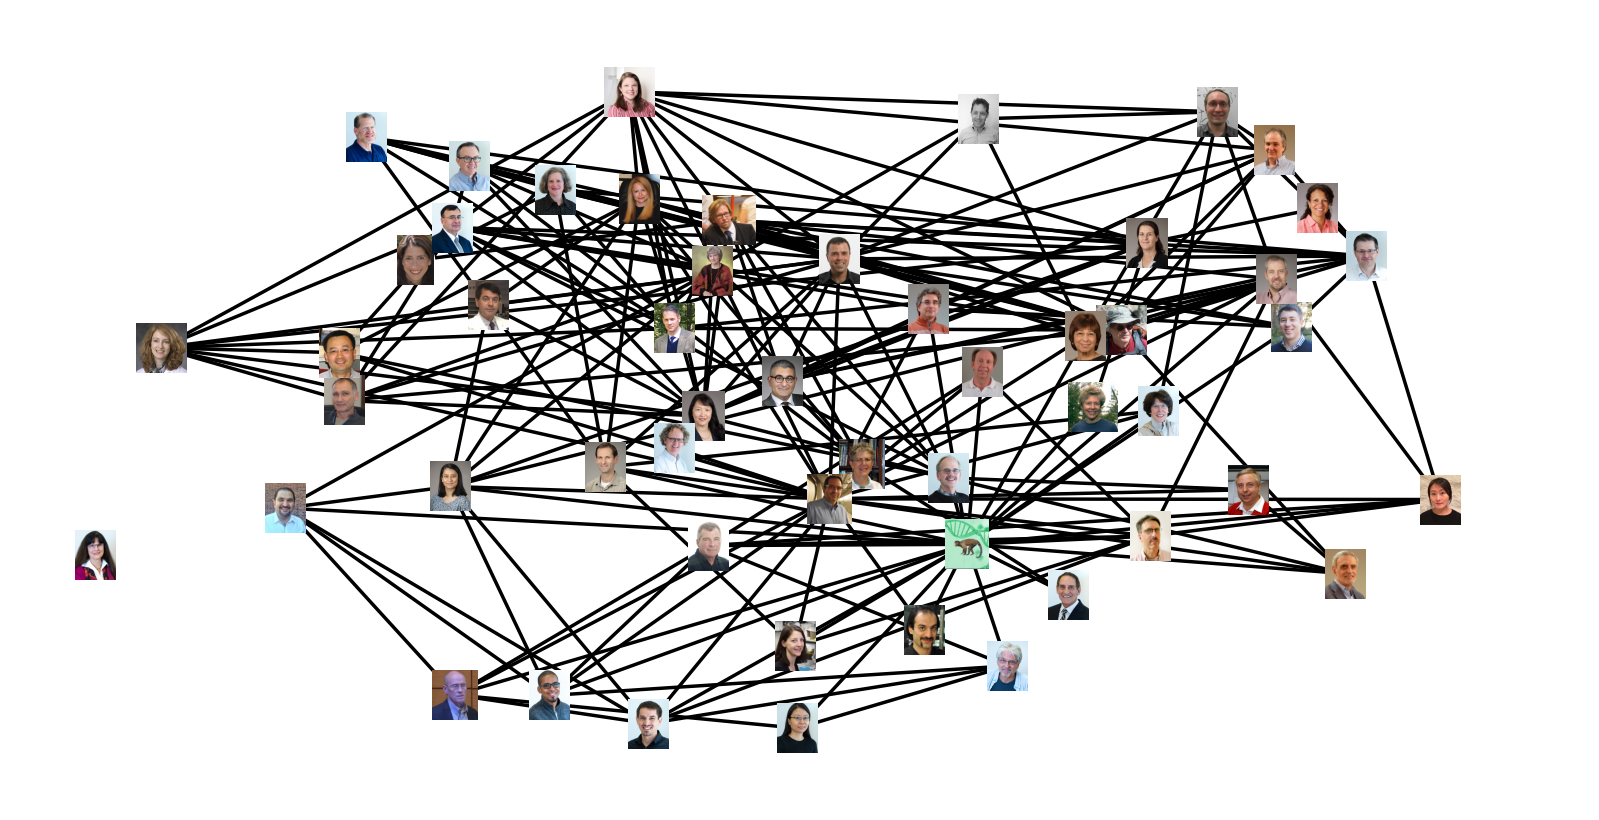

In [311]:
# Based on code from: https://gist.github.com/shobhit/3236373

pos = nx.spring_layout(G, k=1/3, seed=4000)

fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=250)
nx.draw_networkx(G, ax=ax, font_size=5, pos=pos, with_labels=False, node_size=100, node_color='white')
#ax.set_xlim((-1, 1))
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05 # this is the image size
for nn in G.nodes:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    img_path = G.nodes[nn]['img']
    img = Image.open(img_path)
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.axis('off')
    ax.axis('off')
fig.savefig('irp_collaborations_2021reports.png', transparent=True)

/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


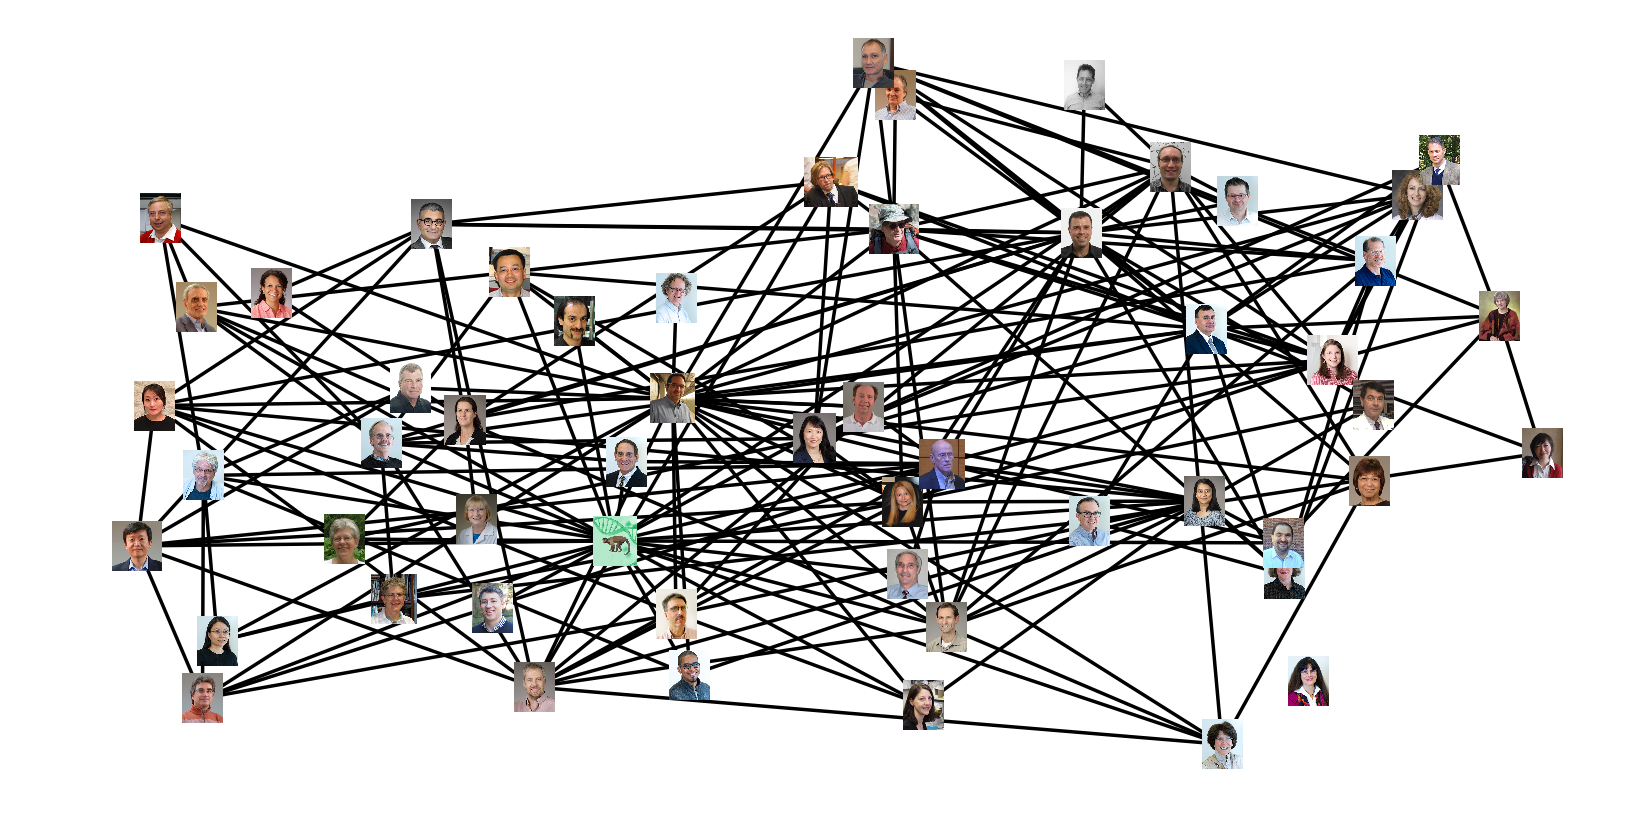

In [632]:
# Based on code from: https://gist.github.com/shobhit/3236373

pos = nx.spring_layout(G, k=1/3, seed=4000)

fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=250)
nx.draw_networkx(G, ax=ax, font_size=5, pos=pos, with_labels=False, node_size=100, node_color='white')
#ax.set_xlim((-1, 1))
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05 # this is the image size
for nn in G.nodes:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    img_path = G.nodes[nn]['img']
    img = Image.open(img_path)
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.axis('off')
    ax.axis('off')
fig.savefig('irp_collaborations.png', transparent=True)

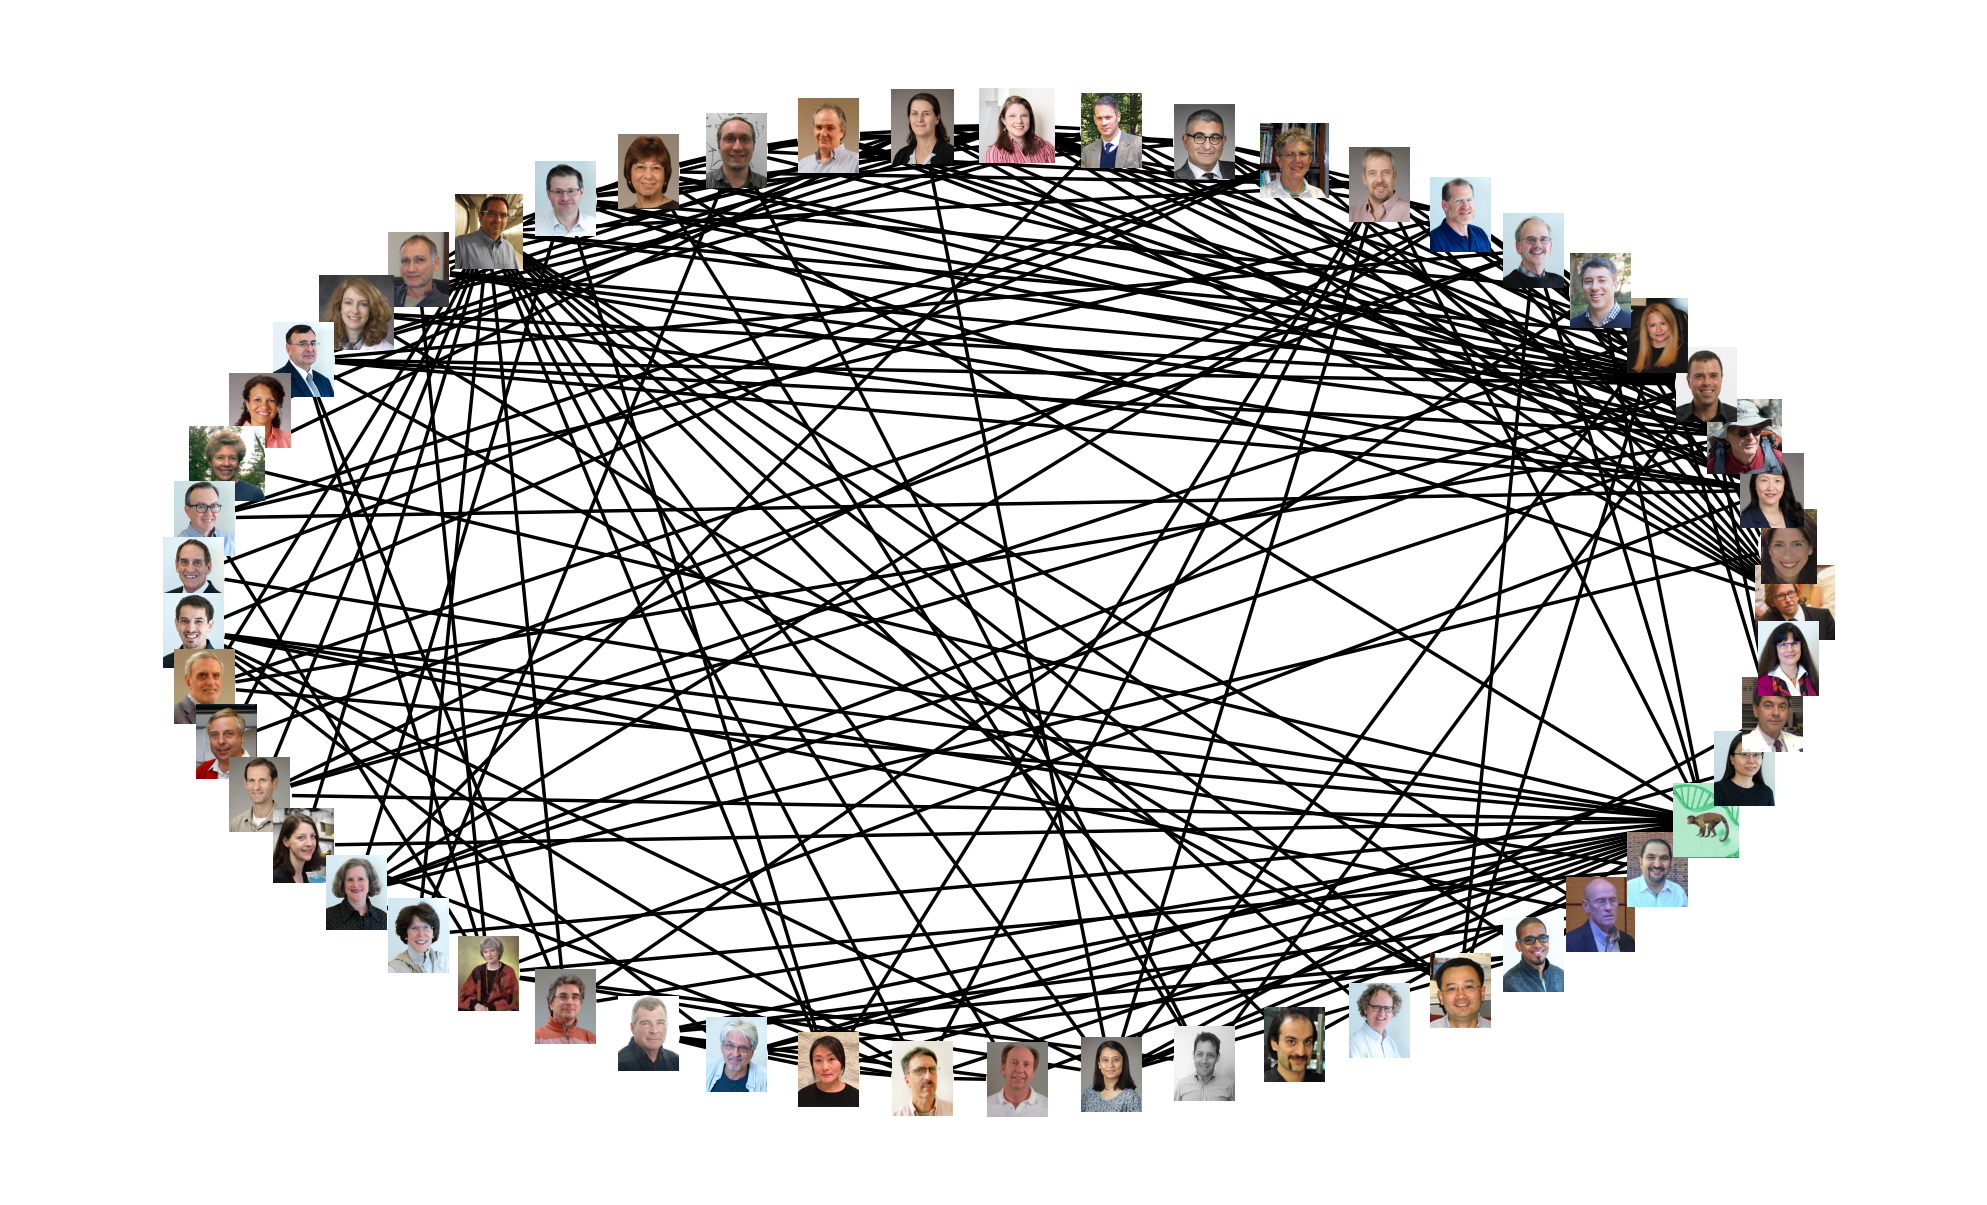

In [312]:
pos = nx.circular_layout(G)
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=250)
nx.draw_networkx(G, ax=ax, font_size=5, pos=pos, with_labels=False, node_size=300, node_color='white')
#ax.set_xlim((-1, 1))
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05 # this is the image size
for nn in G.nodes:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    img_path = G.nodes[nn]['img']
    img = Image.open(img_path)
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.axis('off')
    ax.axis('off')
fig.savefig('irp_collaborations_circle_2021reports.png', transparent=True)

/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


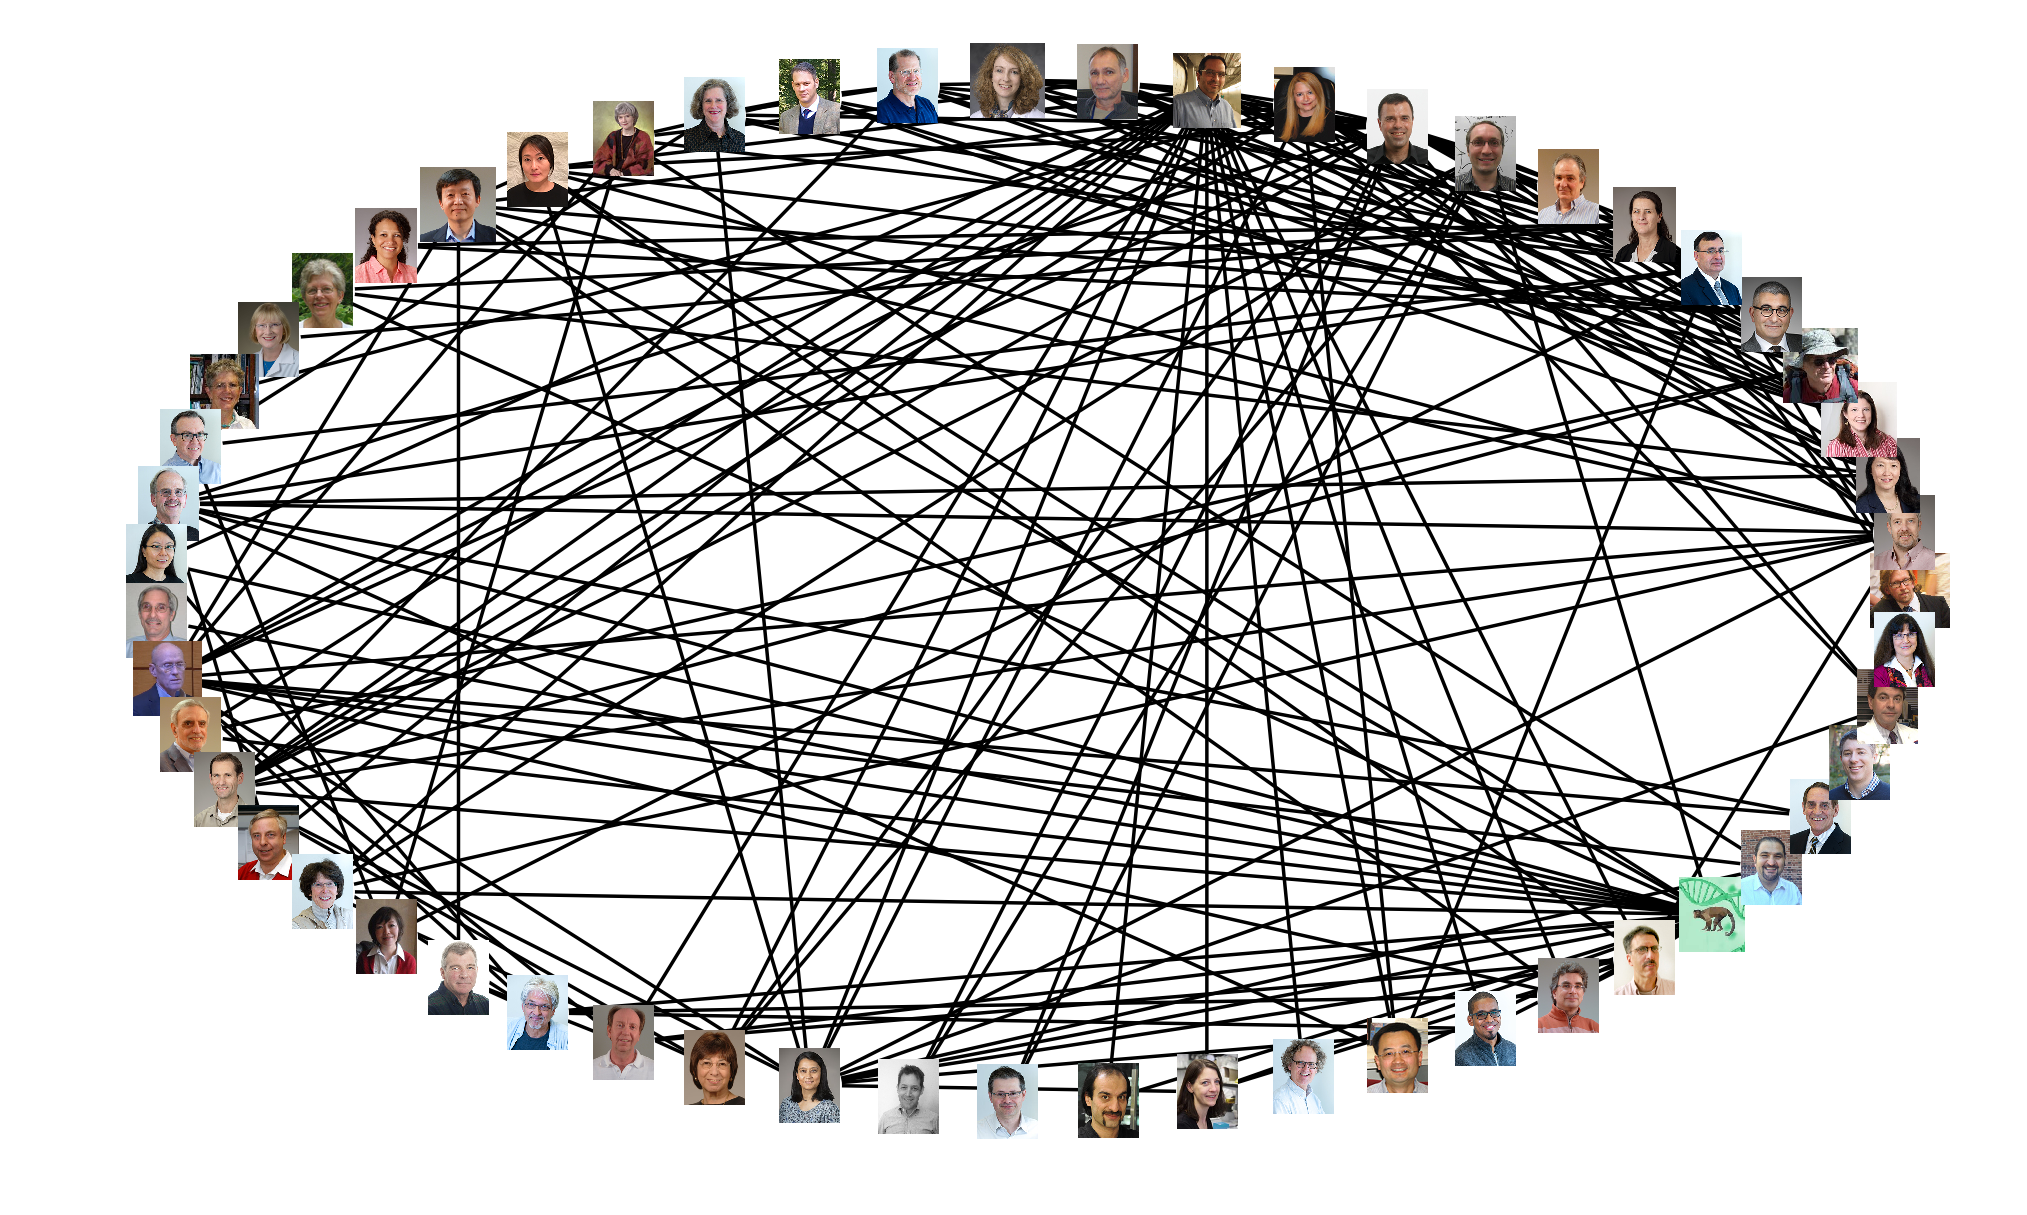

In [633]:
pos = nx.circular_layout(G)
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=250)
nx.draw_networkx(G, ax=ax, font_size=5, pos=pos, with_labels=False, node_size=300, node_color='white')
#ax.set_xlim((-1, 1))
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05 # this is the image size
for nn in G.nodes:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    img_path = G.nodes[nn]['img']
    img = Image.open(img_path)
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.axis('off')
    ax.axis('off')
fig.savefig('irp_collaborations_circle.png', transparent=True)

## Make graph for external collaborators

In [314]:
pi_collab.query('scope == "NIH"').institute.unique()

array(['NINDS', 'NHGRI', 'NICHD', 'NEI', 'NIAMS', 'NIBIB', 'NIDCR', 'CC',
       'NHLBI', 'NIAID', 'NIA', 'NIAAA', 'NIDA', 'NIDDK', 'NINR', 'NCATS',
       'NCCIH', 'CIT', 'OD', 'NCI', 'NIDCD'], dtype=object)

In [315]:
pi_collab['institute'] = pi_collab['institute'].str.strip()

In [ ]:
pi_collab.sample()

In [316]:
x_el = pi_collab.loc[pi_collab.scope=='NIH', ['pi', 'institute']].drop_duplicates().sample(frac=1).to_records(index=False)
x_G = nx.Graph()
x_G.add_edges_from(x_el)

In [317]:
pis = pi_collab.loc[pi_collab.scope=='NIH', 'pi'].unique()
institutes = pi_collab.loc[pi_collab.scope=='NIH', 'institute'].unique()
shells = [institutes,
          pis]

In [318]:
for nn in x_G.nodes:
    try:
        x_G.nodes[nn]['img'] = pic_lut[nn]
    except KeyError:
        pass

In [319]:
palette = sns.color_palette(palette='dark', n_colors=len(institutes))
palette = sns.hls_palette(len(institutes), l=.3, s=.8)
inst_color_lut = {inst:color for inst,color in zip(institutes, palette)}

In [320]:
# Make node color list
node_colors = []
for nn in x_G.nodes:
    if nn in institutes:
        node_colors.append(inst_color_lut[nn]) 
    else:
        node_colors.append((1,1,1))
        
# Make edge color list
edge_colors = []
for n1,n2 in x_G.edges:
    if n1 in institutes:
        edge_colors.append(inst_color_lut[n1])
    else:
        edge_colors.append(inst_color_lut[n2])

In [321]:
# External Stats
n_with_NIH = (pj_df.groupby('PI').NIH_collab.count() > 0).sum()
n_no_NIH = (pj_df.groupby('PI').NIH_collab.count() == 0).sum()
total_collabs = pi_collab.query('scope == "NIH"').shape[0]
total_institutes = pi_collab.query('scope == "NIH"').institute.nunique()

print(f"Total number of collabs: {total_collabs}")
print(f"Unique Institutes: {total_institutes}")
print(f"Number of investigators with non-NIMH IRP collaborators: {n_with_NIH}")
print(f"Number of investigators without non-NIMH IRP collaborators: {n_no_NIH}")

print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_NIH}")
print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
print(f"Mean number of collabs per all PIs but not training: {total_collabs/(n_pi - 1)}")

Total number of collabs: 290
Unique Institutes: 21
Number of investigators with non-NIMH IRP collaborators: 44
Number of investigators without non-NIMH IRP collaborators: 11
Mean number of collabs per PI with collabs: 6.590909090909091
Mean number of collabs per all PIs: 5.2727272727272725
Mean number of collabs per all PIs but not training: 5.37037037037037


In [233]:
# old stats
# External Stats
# n_with_NIH = (pj_df.groupby('PI').NIH_collab.count() > 0).sum()
# n_no_NIH = (pj_df.groupby('PI').NIH_collab.count() == 0).sum()
# total_collabs = pi_collab.query('scope == "NIH"').shape[0]
# total_institutes = pi_collab.query('scope == "NIH"').institute.nunique()

# print(f"Total number of collabs: {total_collabs}")
# print(f"Unique Institutes: {total_institutes}")
# print(f"Number of investigators with non-NIMH IRP collaborators: {n_with_NIH}")
# print(f"Number of investigators without non-NIMH IRP collaborators: {n_no_NIH}")

# print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_NIH}")
# print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
# print(f"Mean number of collabs per all PIs but not training: {total_collabs/(n_pi - 1)}")

Total number of collabs: 303  
Unique Institutes: 20  
Number of investigators with non-NIMH IRP collaborators: 46  
Number of investigators without non-NIMH IRP collaborators: 11  
Mean number of collabs per PI with collabs: 6.586956521739131  
Mean number of collabs per all PIs: 5.315789473684211  
Mean number of collabs per all PIs but not training: 5.410714285714286  

In [322]:
(pj_df.groupby('PI').NIH_collab.count())[(pj_df.groupby('PI').NIH_collab.count() == 0)]

PI
Argyrios  Stringaris, PhD    0
Armin  Raznahan, PhD         0
Bruno B Averbeck, PhD        0
Christian  Grillon, PhD      0
Daniel  Pine, MD             0
Dietmar  Plenz, PhD          0
Elisha Prem Merriam, PhD     0
Heather A Cameron, PhD       0
Janet Elizabeth Clark        0
Leslie G Ungerleider, PhD    0
Melissa A Brotman, PhD       0
Name: NIH_collab, dtype: int64

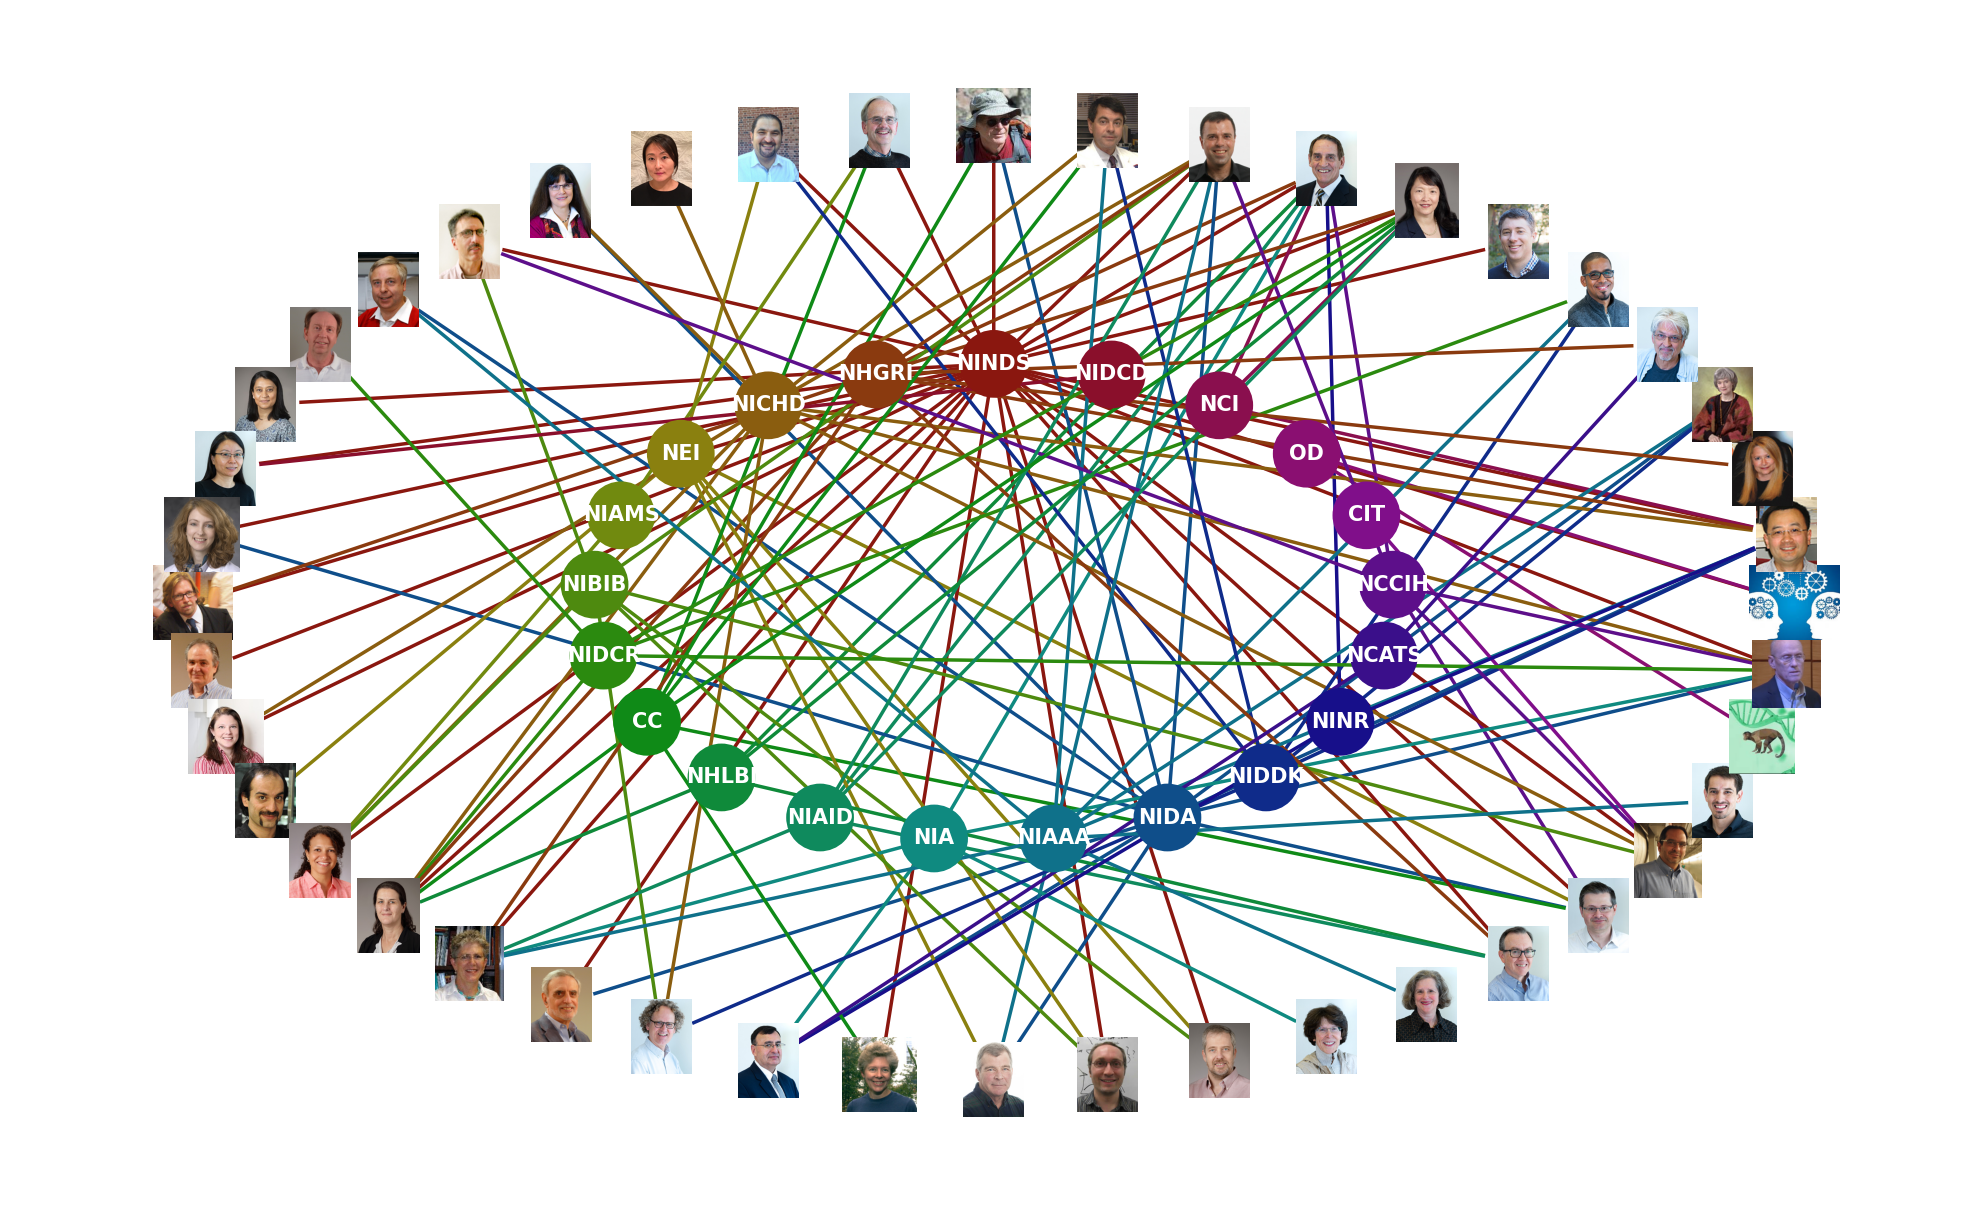

In [323]:
pos = nx.shell_layout(x_G, nlist=shells)
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=250)
nx.draw_networkx(x_G, ax=ax, font_size=5, pos=pos, with_labels=False, node_size=350, node_color=node_colors, edge_color=edge_colors)
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05
for nn in pis:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    img_path = x_G.nodes[nn]['img']
    img = Image.open(img_path)
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.axis('off')
ax.axis('off')
for nn in institutes:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    ax.text(x, y, nn, color='white', size=6, ha='center', va='center', weight='bold')
    
fig.savefig('nih_collaborations_circle_2021report.png', transparent=True)

# save csv for collabs

In [325]:
pi_collab.to_csv(data_path / 'pi_collabs_2021reports.csv', index=None)